In [ ]:
# Swin-BathyUNet: A Swin-Transformer Enhanced U-Net for Shallow Water Bathymetry Using Remote Sensing Imagery and Multi-view Stereo-derived DSMs with Missing Data
# Initial Pytorch Implementation: Panagiotis Agrafiotis (https://github.com/pagraf)
# Email: agrafiotis.panagiotis@gmail.com

# Description:  Swin-BathyUNet, a deep learning model that combines U-Net with Swin Transformer self-attention 
# layers and a cross-attention mechanism, tailored specifically for SDB. Swin-BathyUNet is designed to improve 
# bathymetric accuracy by capturing long-range spatial relationships and can also function as a standalone solution 
# for standard bathymetric mapping with various training depth data, independent of SfM-MVS output.
# It outputs continuous values.

# If you use this code please cite our paper: 

# This .ipynb was structured inspired by the [DeepNetsForEO] (https://github.com/nshaud/DeepNetsForEO) repository.

# Attribution-NonCommercial-ShareAlike 4.0 International License

# Copyright (c) 2024 The MagicBathyNet Authors

# This license requires that reusers give credit to the creator. It allows reusers 
# to distribute, remix, adapt, and build upon the material in any medium or format,
# for noncommercial purposes only. If others modify or adapt the material, they 
# must license the modified material under identical terms.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


# This work is part of MagicBathy project funded by the European Union’s HORIZON Europe research and innovation 
# programme under the Marie Skłodowska-Curie GA 101063294. Work has been carried out at the Remote Sensing Image 
# Analysis group. For more information about the project visit https://www.magicbathy.eu/.

In [ ]:
## GPU

# Enable GPU with `Runtime->Change runtime type->Hardware Accelerator->GPU` in the top menu

In [ ]:
# imports and stuff
import time
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import rasterio
import gdal
import scipy

from bathymetry.swin-bathyunet import *

import sys

from IPython.display import clear_output
import numpy.ma as ma
from torchvision.transforms import RandomCrop, Resize
from skimage.transform import resize, rotate
from sklearn.metrics import mean_squared_error
import scipy.ndimage 
import os
from skimage.transform import resize
from skimage import transform
import cupy as cp

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.init()

In [3]:
# data are assumed to be in MagicBathyNet/ directory (https://www.magicbathy.eu/magicbathynet.html)
FOLDER = '/.../magicbathynet/'
sys.path.append(FOLDER)

# Parameters

In [4]:
# Parameters++++
norm_param = np.load('/.../magicbathynet/agia_napa/norm_param_aerial.npy')
norm_param_depth = -14.556  #-14.556 FOR AGIA NAPA, -5 FOR PUCK LAGOON
WINDOW_SIZE = (720, 720)
WINDOW_SIZE_sfm = (720, 720)
STRIDE = 1
BATCH_SIZE = 1
MAIN_FOLDER = FOLDER

#Agia Napa 
train_images = ['409', '418', '350', '399', '361', '430', '380', '359', '371', '377', '379', '360', '368', '419', '389', '420', '401', '408', '352', '388', '362', '421', '412', '351', '349', '390', '400', '378', '411', '387', '410', '398', '370', '369', '397']#['410', '387', '398', '409', '369', '418', '350', '399', '361', '359', '377', '379', '360', '368', '419', '389', '408', '388', '349', '400', '378']
test_images = train_images

#Puck Lagoon 
#agia napa ['410', '387', '398', '409', '369', '418', '350', '399', '361', '359', '377', '379', '360', '368', '419', '389', '408', '388', '349', '400', '378']
#puck lagoon ['1247', '3221', '640', '1307', '3016', '248', '3157', '3027', '1731', '2474', '2050', '2767', '1885', '768', '2125', '1646', '2317', '2184', '1054', '1476', '753', '644', '2736', '462', '2180', '2403', '1562', '1287', '447', '825', '1725', '2695', '2664', '2481', '1404', '800', '2671', '51', '2286', '2130', '3234', '1020', '2670', '2927', '1627', '942', '3038', '1373', '2330', '1711', '2625', '697', '1456', '2198', '759', '1488', '789', '1889', '385', '2113', '2416', '743', '2727', '2641', '849', '13', '557', '811', '3246', '3186', '926', '1107', '831', '436', '1317', '3215', '2292', '1117', '1010', '1652', '3287', '2919', '1969', '2040', '879', '2029', '504', '1879', '693', '821', '2929', '11', '3195', '286', '1573', '1220', '3020', '1660', '3181', '1323', '519', '2685', '2493', '2601', '1548', '562', '1974', '1163', '334', '140', '1956', '2483', '300', '571', '372', '702', '441', '2318', '1800', '1028', '2779', '3150', '2991', '2609', '333', '3230', '474', '2745', '657', '1891', '389', '3199', '2665', '313', '443', '2039', '2194', '2131', '423', '2694', '2542', '2512', '2064', '3307', '3263', '3285', '2956', '59', '1022', '488', '12', '3264', '234', '1305', '2868', '99', '1570', '1131', '2464', '1380', '915', '2278', '410', '852', '2405', '1203', '950', '387', '677', '1031', '506', '2518', '730', '1375', '2603', '2842', '1183', '695', '486', '199', '2055', '706', '542', '1017', '1825', '2138', '2324', '1795', '1714', '47', '14', '1069', '101', '1098', '525', '1013', '931', '748', '735', '2067', '3261', '1286', '642', '434', '858', '0', '1480', '3114', '2604', '2617', '2196', '1285', '261', '2908', '2175', '1467', '3159', '1313', '843', '3174', '1468', '282', '350', '2988', '2051', '401', '1357', '1649', '961', '3237', '986', '294', '242', '882', '492', '3255', '2094', '2876', '787', '3247', '501', '2098', '2715', '2209', '1713', '3021', '970', '2559', '284', '2989', '2034', '151', '3029', '507', '1006', '1955', '143', '1647', '3302', '2777', '619', '1034', '2610', '2134', '1127', '3223', '3178', '1308', '648', '1737', '2208', '733', '610', '524', '3267', '2122', '597', '891', '520', '583', '2550', '1369', '914', '738', '2334', '746', '2681', '1655', '788', '3133', '3269', '2448', '696', '3018', '798', '799', '2476', '1576', '589', '2532', '452', '1300', '3172', '2261', '3256', '941', '1052', '2660', '522', '1565', '1071', '16', '2879', '354', '2918', '2188', '392', '3274', '701', '585', '1739', '536', '601', '1568', '1213', '3017', '2382', '1391', '367', '2825', '1016', '97', '2717', '2843', '1196', '2485', '2348', '549', '2057', '3288', '2355', '1011', '1207', '2571', '3149', '512', '2056', '402', '949', '2733', '1130', '1218', '2794', '1708', '411', '2105', '1232', '3104', '3108', '2044', '2606', '2269', '355', '1978', '2119', '3107', '1474', '2573', '2412', '560', '3182', '2662', '3295', '2354', '756', '2928', '3254', '2994', '1217', '448', '2472', '1985', '3232', '861', '2347', '2867', '1493', '2540', '1292', '2873', '2423', '405', '716', '2385', '1728', '8', '775', '338', '2589', '3158', '2273', '3201', '2528', '3125', '2410', '2612', '3222', '620', '854', '742', '899', '511', '1796', '2137', '2822', '1798', '2108', '15', '2359', '1122', '193', '2945', '1147', '2420', '617', '1486', '552', '3240', '243', '3002', '674', '669', '1129', '503', '1226', '766', '42', '2248', '928', '751', '1118', '1736', '497', '1005', '2488', '1199', '3081', '2548', '404', '765', '3066', '1735', '321', '2732', '1072', '1465', '2399', '2558', '2872', '1390', '2409', '2611', '3183', '2478', '1210', '2847', '470', '1477', '548', '1954', '3059', '489', '1270', '3298', '1634', '1405', '1032', '2414', '1543', '420', '150', '2632', '1799', '1546', '1466', '1464', '297', '784', '969', '2482', '534', '3248', '2255', '3000', '3213', '622', '2631', '2674', '658', '1393', '2271', '2798', '1133', '1316', '3179', '654', '2678', '2541', '660', '3113', '2607', '3067', '1809', '1225', '3035', '2406', '2496', '785', '3095', '2341', '664', '490', '2783', '2515', '2912', '2356', '2618', '2259', '1144', '723', '2725', '570', '966', '1221', '792', '1907', '2201', '3140', '637', '2765', '3015', '2469', '857', '2543', '1135', '968', '3131', '565', '3056', '1469', '2723', '896', '2186', '1018', '898', '630', '1029', '625', '2123', '1563', '2489', '3076', '1037', '736', '1109', '2926', '1389', '298', '1383', '2885', '2718', '1269', '3080', '1100', '2553', '2048', '1637', '938', '2554', '1157', '1460', '778', '2118', '2133', '2265', '1249', '3164', '2192', '92', '1574', '440', '758', '1803', '611', '2946', '2387', '728', '369', '309', '2477', '2211', '2206', '2889', '1886', '2520', '2634', '1559', '266', '1824', '566', '595', '553', '1874', '1291', '802', '951', '1246', '3204', '2954', '1211', '3192', '815', '1489', '2778', '2888', '2030', '2672', '2578', '2958', '412', '3239', '681', '265', '48', '1972', '574', '923', '469', '3139', '769', '465', '516', '3096', '5', '2821', '927', '1569', '416', '1320', '2058', '3019', '1963', '3251', '2430', '672', '1289', '238', '627', '860', '2214', '847', '2786', '2677', '2281', '1717', '1727', '1567', '1387', '301', '3078', '859', '1893', '767', '2103', '1021', '3057', '2549', '2985', '264', '2349', '3249', '2128', '1007', '1888', '2967', '1139', '1228', '807', '1566', '2268', '953', '3252', '1026', '952', '147', '2287', '2466', '773', '1114', '1560', '3132', '2319', '837', '1629', '2213', '2833', '543', '2830', '892', '386', '149', '2834', '3085', '2511', '1099', '823', '1553', '813', '734', '498', '777', '2948', '2555', '1625', '2357', '2552', '727', '762', '704', '2982', '2716', '3111', '3212', '764', '1983', '2252', '916', '2272', '2283', '1224', '141', '351', '195', '2514', '878', '962', '2784', '3216', '249', '3235', '200', '2144', '2576', '1903', '2411', '303', '1473', '194', '2747', '2199', '1966', '6', '1310', '1740', '513', '197', '396', '96', '1481', '1388', '202', '311', '342', '2570', '339', '2498', '981', '944', '317', '2181', '1738', '3055', '10', '1487', '1965', '1814', '2658', '2748', '390', '836', '689', '413', '1979', '2600', '688', '937', '3123', '1734', '3115', '1712', '848', '2344', '2171', '463', '1880', '594', '1539', '779', '3286', '362', '2561', '1895', '450', '2275', '2360', '98', '685', '2097', '60', '509', '2531', '3198', '457', '3297', '822', '41', '1132', '2907', '1890', '808', '186', '554', '2426', '2096', '3058', '2981', '2887', '1030', '2203', '1312', '424', '2121', '1115', '3088', '1215', '2129', '2643', '3194', '3135', '3268', '1162', '967', '954', '2045', '437', '1302', '2276', '2473', '1643', '1142', '361', '598', '438', '2052', '862', '106', '2316', '1146', '502', '3165', '567', '643', '102', '3276', '1822', '2046', '2335', '1381', '3155', '3051', '399', '1490', '442', '3134', '1571', '1197', '3253', '2467', '2110', '2182', '614', '676', '774', '3196', '791', '50', '2383', '1230', '1733', '652', '53', '901', '963', '1111', '745', '468', '1040', '1050', '391', '94', '1906', '2737', '2419', '2910', '3236', '2984', '1301', '146', '629', '103', '1897', '3161', '607', '2059', '2402', '2455', '934', '1898', '2613', '2246', '618', '1156', '2054', '2047', '2622', '1396', '2260', '2351', '2949', '874', '3180', '1892', '604', '1459', '544', '3122', '760', '1572', '1296', '893', '877', '667', '1012', '1724', '283', '550', '1121', '2253', '781', '255', '2990', '2032', '2772', '1401', '1067', '3141', '1283', '2952', '592', '192', '2844', '2471', '3290', '1386', '1108', '645', '1721', '1245', '2320', '593', '772', '1962', '2729', '850', '1485', '1982', '880', '2095', '715', '319', '2521', '1479', '510', '1123', '1882', '2205', '911', '2551', '1043', '864', '1024', '2642', '95', '2766', '349', '3282', '2560', '2771', '2738', '838', '1314', '679', '1638', '2686', '818', '2619', '3068', '1095', '1491', '1626', '1815', '2350', '148', '409', '1810', '921', '666', '3289', '142', '187', '1718', '368', '1483', '2667', '2627', '2179', '2282', '2353', '2491', '2274', '1970', '2730', '1706', '2459', '456', '1209', '458', '2215', '91', '2878', '1639', '1356', '731', '1322', '3110', '2450', '1653', '2202', '881', '809', '296', '1538', '2605', '241', '933', '2827', '810', '2331', '2035', '1402', '824', '812', '3175', '1113', '2340', '2495', '2749', '2247', '419', '1802', '471', '2782', '1622', '747', '1070', '1223', '1462', '1250', '3304', '89', '2635', '2277', '987', '1812', '1475', '137', '626', '3217', '680', '346', '1790', '694', '940', '2174', '1184', '1202', '687', '740', '3303', '1229', '2479', '1820', '2421', '1986', '1125', '2343', '539', '1555', '713', '240', '364', '451', '1395', '1807', '2244', '1823', '613', '2513', '3026', '2132', '2724', '2696', '3087', '518', '2682', '3275', '750', '3129', '3262', '1271', '2061', '526', '1544', '3277', '3294', '365', '2418', '295', '2911', '3065', '384', '678', '1137', '3265', '3292', '2666', '2408', '3003', '547', '90', '2533', '2963', '198', '3296', '239', '1145', '2458', '293', '2557', '1742', '1110', '537', '2065', '1216', '262', '1732', '2107', '3028', '1950', '853', '260', '639', '1158', '3241', '2877', '707', '551', '1720', '1801', '3105', '2060', '1399', '2616', '2333', '1073', '2875', '1542', '2386', '556', '348', '2866', '2401', '971', '755', '3112', '3170', '782', '1160', '2986', '1141', '1057', '2291', '3250', '925', '2608', '1297', '1715', '2391', '661', '1023', '418', '2669', '979', '54', '398', '650', '1039', '1797', '2315', '236', '988', '2332', '1958', '2212', '2575', '2173', '584', '922', '472', '2413', '1961', '2139', '2101', '936', '417', '191', '2336', '603', '2829', '826', '2031', '359', '2345', '184', '1577', '856', '2776', '344', '2527', '1035', '2172', '494', '2480', '3052', '289', '320', '476', '655', '1319', '2530', '1461', '2914', '545', '2831', '588', '844', '1635', '705', '1311', '662', '3154', '1204', '2250', '2346', '58', '318', '1295', '1901', '3151', '1624', '421', '1385', '415', '2475', '2964', '46', '783', '2992', '984', '2774', '3138', '1549', '2428', '1628', '1623', '1048', '1208', '647', '188', '1235', '1074', '1299', '2993', '616', '3049', '61', '445', '3137', '873', '435', '2358', '872', '3301', '1138', '2871', '3001', '741', '291', '2797', '340', '1883', '2111', '1290', '2185', '2722', '2987', '3023', '2826', '805', '924', '1547', '2547', '3202', '1454', '2279', '2676', '561', '395', '656', '1045', '2415', '1355', '1051', '803', '2675', '1658', '606', '1140', '3004', '965', '2143', '2042', '495', '3280', '459', '600', '3053', '1904', '100', '3089', '2629', '1049', '1722', '946', '1306', '1134', '1707', '1058', '1872', '2995', '499', '1636', '2142', '1951', '2624', '244', '1101', '863', '3022', '932', '1027', '505', '2917', '1644', '1124', '2679', '2398', '2545', '1719', '780', '801', '2644', '1630', '1541', '763', '842', '3203', '692', '235', '649', '444', '1148', '2865', '2468', '1458', '1743', '2519', '2219', '453', '1788', '153', '2425', '3162', '2773', '569', '720', '2726', '744', '464', '1730', '948', '1376', '3148', '587', '1403', '508', '1905', '3220', '1564', '638', '1379', '475', '1977', '3037', '1540', '1981', '1463', '3205', '3309', '2388', '2628', '2785', '1309', '673', '608', '2337', '820', '2832', '315', '2577', '2546', '1303', '726', '1819', '310', '454', '2207', '2950', '1374', '699', '900', '591', '2680', '1231', '1632', '3187', '1648', '2683', '943', '1398', '754', '2449', '3047', '3048', '3206', '2770', '761', '2697', '2823', '1793', '3238', '1161', '3084', '724', '3173', '1470', '575', '1408', '1645', '1957', '2529', '2516', '599', '1400', '2284', '563', '1789', '887', '698', '2614', '52', '2053', '2780', '1298', '304', '2266', '2249', '347', '757', '841', '2720', '1227', '1284', '876', '3171', '2453', '1014', '523', '875', '56', '3054', '3218', '3025', '491', '1884', '254', '1871', '1', '1212', '1492', '3094', '2721', '1896', '1545', '2490', '1551', '2955', '2886', '918', '2916', '2043', '947', '2470', '2668', '752', '2267', '1805', '3130', '3106', '1304', '136', '1729', '2795', '3279', '912', '1159', '2187', '2845', '363', '1068', '393', '2572', '541', '353', '515', '602', '2197', '371', '3219', '1236', '675', '576', '485', '2841', '913', '2890', '2063', '1397', '2264', '790', '2768', '1484', '1457', '1900', '1894', '1557', '2840', '2417', '3193', '1394', '337', '1973', '2210', '2544', '978', '833', '2828', '1657', '190', '2884', '2965', '352', '292', '1971', '628', '7', '700', '299', '335', '460', '138', '830', '1096', '2457', '44', '2384', '1964', '691', '829', '2602', '1873', '1631', '3156', '2497', '2947', '894', '1952', '605', '201', '1806', '3233', '1661', '1384', '2588', '2066', '366', '690', '1033', '1025', '2245', '1206', '9', '408', '804', '555', '2422', '1149', '397', '2135', '2713', '2510', '414', '1056', '3278', '2465', '2424', '3207', '45', '466', '1987', '659', '1248', '1120', '467', '246', '1876', '609', '3', '43', '3082', '3147', '945', '3163', '2321', '285', '1222', '2494', '1482', '653', '1975', '2587', '615', '1044', '2796', '840', '2874', '2968', '939', '1875', '573', '686', '729', '104', '1870', '845', '1804', '929', '3124', '2339', '383', '2746', '1038', '1318', '1472', '683', '1980', '612', '559', '2062', '1654', '2254', '2661', '3214', '3231', '2109', '2633', '1214', '57', '493', '1066', '1821', '2251', '3097', '1234', '1198', '2270', '1656', '980', '1726', '1042', '2719', '835', '865', '2586', '828', '3197', '1294', '1370', '290', '3024', '345', '2124', '473', '2714', '1055', '889', '2930', '3034', '1552', '1877', '2913', '2712', '1818', '3109', '2925', '2775', '1378', '3308', '682', '817', '3086', '1097', '568', '1200', '2957', '1984', '332', '834', '888', '2178', '3185', '564', '1550', '1887', '517', '2492', '725', '538', '3077', '312', '1902', '185', '3160', '1651', '3224', '2915', '786', '487', '144', '832', '2033', '314', '196', '2117', '2041', '1878', '2983', '732', '718', '2556', '341', '1794', '2630', '1556', '964', '2342', '1392', '1650', '1143', '1741', '2325', '1075', '596', '1059', '717', '1881', '2338', '1036', '336', '400', '2389', '3153', '2290', '1008', '2', '1710', '739', '2140', '55', '3083', '2870', '1633', '897', '2451', '1136', '370', '422', '977', '851', '771', '1321', '49', '1899', '2126', '105', '461', '621', '245', '1471', '3079', '2728', '1575', '1358', '1407', '703', '846', '2734', '917', '1968', '663', '2400', '919', '2195', '1976', '2170', '152', '2846', '714', '3136', '93', '670', '2285', '546', '558', '2687', '2953', '920', '586', '1659', '1959', '1813', '2361', '2673', '770', '2731', '1811', '2456', '2951', '827', '2487', '521', '985', '2429', '2735', '247', '2120', '1372', '2824', '890', '2966', '572', '2769', '1478', '3036', '2404', '2663', '1817', '982', '3266', '2177', '737', '651', '2623', '237', '1406', '623', '1293', '1041', '3177', '719', '407', '3103', '1053', '816', '646', '1119', '514', '2615', '2781', '2659', '1116', '2390', '2427', '2112', '446', '139', '1205', '403', '2484', '500', '287', '3281', '1377', '449', '1561', '455', '814', '1233', '2193', '3184', '2569', '3176', '360', '2200', '1009', '2869', '2574', '2352', '2626', '540', '3291', '3050', '288', '895', '684', '1382', '2486', '2204', '1455', '1128', '819', '1126', '624', '2049', '1219', '2280', '2454', '855', '1554', '2102', '641', '496', '2684', '4', '535', '145', '2218', '439', '776', '533', '1315', '1816', '1967', '250', '1808', '394', '2407', '3200', '1960', '302', '2127', '983', '2104', '1371', '2909', '343', '1716', '2136', '910']

num_train_images = len(train_images)*2

print(norm_param)
print(norm_param.shape)


net = UNetWithAttention(in_channels=3, out_channels=1)


base_lr = 0.00025 # 0.000125 for PUCK LAGOON AERIAL


CACHE = False # Store the dataset in-memory

IMG_FOLDER = MAIN_FOLDER + 'agia_napa/img/aerial/img_{}.tif'
SFM_FOLDER = MAIN_FOLDER + 'agia_napa/depth/aerial_sfm/sfm_{}.tif'
LIDAR_FOLDER = MAIN_FOLDER + 'agia_napa/depth/aerial_interpolated/interpolated_depth_{}.tif'

[[  0   0   0]
 [255 255 255]]
(2, 3)



# Visualizing the dataset

First, let's check that we are able to access the dataset and see what's going on. We use scikit-image for image manipulation.

As the ISPRS dataset is stored with a ground truth in the RGB format, we need to define the color palette that can map the label id to its RGB color. We define two helper functions to convert from numeric to colors and vice-versa.


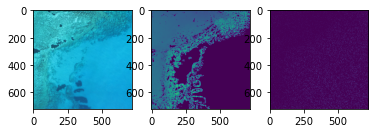

In [5]:
# We load one tile from the dataset and we display it
img = io.imread(MAIN_FOLDER+'agia_napa/img/aerial/img_410.tif')
#print(img.shape)
fig = plt.figure()
fig.add_subplot(131)
norm_img = (img - norm_param[0]) / (norm_param[1] - norm_param[0]) 
plt.imshow(norm_img)

# We load the ground truth
gt = io.imread(MAIN_FOLDER+'agia_napa/depth/aerial_sfm/sfm_410.tif')
fig.add_subplot(132)
plt.imshow(gt/norm_param_depth)
#print(gt/norm_param_depth)

# We load the LiDAR ground truth
gt_lidar = io.imread(MAIN_FOLDER+'agia_napa/depth/aerial/depth_410.tif')
fig.add_subplot(133)
plt.imshow(gt_lidar/norm_param_depth)
#print(gt_lidar/norm_param_depth)

plt.show()

We need to define a bunch of utils functions.

In [6]:
# Utils


def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w)
    x2 = x1 + w
    y1 = random.randint(0, H - h)
    y2 = y1 + h
    return x1, x2, y1, y2

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics_test(predictions, gts, mask):

    # Ensure inputs are on the GPU
    predictions = cp.asarray(predictions)
    gts = cp.asarray(gts)
    mask = cp.asarray(mask)
    # Exclude 0 values from calculation
    non_zero_mask = mask != 0
    
    # Calculate RMSE, MAE, and collect predictions and targets
    rmse = cp.sqrt(cp.mean(((predictions - gts) ** 2)[non_zero_mask]))*-norm_param_depth
    mae = cp.mean(cp.abs((predictions - gts)[non_zero_mask]))*-norm_param_depth
    std_dev = cp.std((predictions - gts)[non_zero_mask])*-norm_param_depth
    
    print("RMSE : {:.3f}m".format(rmse))
    print("MAE : {:.3f}m".format(mae))
    print("Std_Dev : {:.3f}m".format(std_dev))
    print("---")
    
    return rmse

def metrics(predictions, gts):

    # Ensure inputs are on the GPU
    predictions = cp.asarray(predictions)
    gts = cp.asarray(gts)

    # Exclude 0 values from calculation
    non_zero_mask = gts != 0
    
    # Calculate RMSE, MAE, and collect predictions and targets
    rmse = cp.sqrt(cp.mean(((predictions - gts) ** 2)[non_zero_mask]))*-norm_param_depth
    mae = cp.mean(cp.abs((predictions - gts)[non_zero_mask]))*-norm_param_depth
    std_dev = cp.std((predictions - gts)[non_zero_mask])*-norm_param_depth
    
    print("RMSE : {:.3f}m".format(rmse))
    print("MAE : {:.3f}m".format(mae))
    print("Std_Dev : {:.3f}m".format(std_dev))
    print("---")
    
    return rmse


def read_geotiff(filename, b):
    ds = gdal.Open(filename)
    band = ds.GetRasterBand(b)
    arr = band.ReadAsArray()
    return arr, ds

def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    band = out_ds.GetRasterBand(1)
    band.WriteArray(arr)
    band.FlushCache()
    band.ComputeStatistics(False)


# Loading the dataset

We define a PyTorch dataset (`torch.utils.data.Dataset)` that loads all the tiles in memory and performs random sampling. Tiles are stored in memory on the fly.

The dataset also performs random data augmentation (horizontal and vertical flips) and normalizes the data in [0, 1].

In [7]:
# Dataset class
from scipy.ndimage import gaussian_filter
random.seed(1)
        
class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, img_files=IMG_FOLDER, sfm_files=SFM_FOLDER, lidar_files=LIDAR_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.img_files = [IMG_FOLDER.format(id) for id in ids]
        self.sfm_files = [SFM_FOLDER.format(id) for id in ids]
        self.lidar_files = [LIDAR_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
        for f in self.img_files + self.sfm_files + self.lidar_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
        
        # Initialize cache dicts
        self.img_cache_ = {}
        self.sfm_cache_ = {}
        self.lidar_cache_ = {}
            
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return num_train_images
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        while True:
            # Pick a random image
            random_idx = random.randint(0, len(self.img_files) - 1)

            # If the tile hasn't been loaded yet, put in cache
            if random_idx in self.img_cache_.keys():
                data = self.img_cache_[random_idx]
            else:
                # Data is normalized in [0, 1]
                data = np.asarray(io.imread(self.img_files[random_idx]).transpose((2,0,1)), dtype='float32')
                data = (data - norm_param[0][:, np.newaxis, np.newaxis]) / (norm_param[1][:, np.newaxis, np.newaxis] - norm_param[0][:, np.newaxis, np.newaxis]) 

                
                if self.cache:
                    self.img_cache_[random_idx] = data

            if random_idx in self.sfm_cache_.keys():
                label_sfm = self.sfm_cache_[random_idx]
            else: 
                # Labels are converted from RGB to their numeric values
                label_sfm = 1/norm_param_depth * np.asarray(io.imread(self.sfm_files[random_idx]), dtype='float32')
                
 
                
                if self.cache:
                    self.sfm_cache_[random_idx] = label_sfm

            if random_idx in self.lidar_cache_.keys():
                label_lidar = self.lidar_cache_[random_idx]
            else: 
                # Labels are converted from RGB to their numeric values
                label_lidar = 1/norm_param_depth * np.asarray(io.imread(self.lidar_files[random_idx]), dtype='float32')

                
                if self.cache:
                    self.lidar_cache_[random_idx] = label_lidar

            #x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
            data_p = data#[:, x1:x2, y1:y2]
            label_sfm_p = label_sfm#[x1:x2, y1:y2]
            label_lidar_p = label_lidar#[x1:x2, y1:y2]


            data_p, label_sfm_p, label_lidar_p = self.data_augmentation(data_p, label_sfm_p, label_lidar_p)
            
            data_p = torch.from_numpy(data_p)
            label_sfm_p = torch.from_numpy(label_sfm_p)
            label_lidar_p =   torch.from_numpy(label_lidar_p)
            
#             data_p = F.interpolate(data, size=128, mode='nearest')
#             label_sfm_p = F.interpolate(target.unsqueeze(1), size=128, mode='nearest')
#             label_lidar_p = F.interpolate(lidar.unsqueeze(1), size=128, mode='nearest')
            
            return data_p, label_sfm_p, label_lidar_p

      

# Network definition 

We can now instantiate the network using the specified parameters. By default, the weights will be initialized using the [He policy](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) (i.e. zero-mean Gaussian distribution whose standard deviation is `√(2/n) `for a layer with `n` response connections and `b=0`).


Then, we load the network on GPU.


In [8]:
net = net.to(device)


# Loading the data

We now create a train/test split. If you want to use another dataset, you have to adjust the method to collect all filenames. In our case, we specify a fixed train/test split for the demo.


In [9]:
# Load the datasets
all_files = sorted(glob(SFM_FOLDER.replace('{}', '*')))
all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]

# Random tile numbers for train/test split
#train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
#test_ids = list(set(all_ids) - set(train_ids))

train_ids = train_images
test_ids = test_images

print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)

train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)



Tiles for training :  ['409', '418', '350', '399', '361', '430', '380', '359', '371', '377', '379', '360', '368', '419', '389', '420', '401', '408', '352', '388', '362', '421', '412', '351', '349', '390', '400', '378', '411', '387', '410', '398', '370', '369', '397']
Tiles for testing :  ['409', '418', '350', '399', '361', '430', '380', '359', '371', '377', '379', '360', '368', '419', '389', '420', '401', '408', '352', '388', '362', '421', '412', '351', '349', '390', '400', '378', '411', '387', '410', '398', '370', '369', '397']



# Designing the optimizer

We use the standard Stochastic Gradient Descent algorithm to optimize the network's weights.

The encoder is trained at half the learning rate of the decoder, as we rely on the pre-trained VGG-16 weights. We use the `torch.optim.lr_scheduler` to reduce the learning rate by 10 after 25, 35 and 45 epochs.


In [10]:
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import CosineAnnealingLR

params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr}]  ###############################################        params += [{'params':[value],'lr': base_lr / 2}]  

optimizer = optim.Adam(net.parameters(), lr=base_lr)
scheduler = CosineAnnealingLR(optimizer, T_max=10)  # T_max is the number of epochs

In [11]:
crop_size_t = 720
pad_size = 16

def test(net, test_ids):
    
    # Use the network on the test set
    test_images = ((np.asarray(io.imread(IMG_FOLDER.format(id)), dtype='float32') - norm_param[0]) / (norm_param[1] - norm_param[0]) for id in test_ids)

    test_labels_sfm = [1 / norm_param_depth * np.asarray(io.imread(SFM_FOLDER.format(id)), dtype='float32') for id in test_ids]
    eroded_labels_sfm = [1 / norm_param_depth * np.asarray(io.imread(SFM_FOLDER.format(id)), dtype='float32') for id in test_ids]
        
    test_labels_lidar = [1 / norm_param_depth * np.asarray(io.imread(LIDAR_FOLDER.format(id)), dtype='float32') for id in test_ids]
    eroded_labels_lidar = [1 / norm_param_depth * np.asarray(io.imread(LIDAR_FOLDER.format(id)), dtype='float32') for id in test_ids]
    
    all_preds = []

    # Switch the network to inference mode
    net.eval()
    
    ratio = crop_size_t / WINDOW_SIZE[0]
    
    for img, gt_sfm, gt_e_sfm, gt_lidar, gt_e_lidar in tqdm(zip(test_images, test_labels_sfm, eroded_labels_sfm, test_labels_lidar, eroded_labels_lidar), total=len(test_ids), leave=False):
        img = scipy.ndimage.zoom(img, (ratio, ratio, 1), order=1)
        
        gt_lidar = scipy.ndimage.zoom(gt_lidar, (ratio, ratio), order=1)
        gt_e_lidar = scipy.ndimage.zoom(gt_e_lidar, (ratio, ratio), order=1)
        
        # Pad the image, ground truth, and eroded ground truth with reflection
        img = np.pad(img, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='reflect')
        
        gt_lidar = np.pad(gt_lidar, ((pad_size, pad_size), (pad_size, pad_size)), mode='reflect')
        gt_e_lidar = np.pad(gt_e_lidar, ((pad_size, pad_size), (pad_size, pad_size)), mode='reflect')
        

        img_tensor = np.copy(img).transpose((2, 0, 1))
        img_tensor = np.expand_dims(img_tensor, axis=0)
        img_tensor = torch.from_numpy(img_tensor).cuda()

        with torch.no_grad():
            outs = net(img_tensor.float())
            pred = outs.data.cpu().numpy().squeeze()

        # Remove padding from prediction
        pred = pred[pad_size:-pad_size, pad_size:-pad_size]

        # Append predictions
        all_preds.append(pred)

    # Returning only the predictions
    return all_preds


# Training the network

Let's train the network for 1 epoch to see how it works (back at work, better train for 50 epochs). The `matplotlib` graph is periodically udpated with the loss plot and a sample inference. It might takes a few minutes on GPUs in the cloud.

If using the notebook on your own machine with the full 50 epochs, depending on your GPU, this might take from a few hours (Titan Pascal) to a full day (old K20).


In [12]:
crop_size = 720
size=(720, 720)
loss_weight = 1.0
epoch_folder = '/.../magicbathynet/epoch_folder/'  

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as F2
from torch.autograd import Variable
import math

from scipy.ndimage import distance_transform_edt

import torch
import torch.nn as nn
import numpy as np
from scipy.ndimage import distance_transform_edt

class CustomLossW(nn.Module):
    def __init__(self, max_distance=5, min_distance=0, decay='linear'):
        super(CustomLossW, self).__init__()
        self.max_distance = max_distance
        self.min_distance = min_distance
        self.decay = decay

    def forward(self, output, depth, mask):
        
        def distance_transform_edt_cuda(mask):
            mask_np = mask.cpu().numpy()
            distances = np.zeros_like(mask_np, dtype=np.float32)

            for i in range(mask_np.shape[0]):
                distance_edt = distance_transform_edt(mask_np[i] == 1)
                distances[i] = distance_edt

            return torch.tensor(distances, device=mask.device) 
        distances = distance_transform_edt_cuda(mask)

        # Clip distances to min_distance and max_distance
        distances = torch.clamp(distances, min=self.min_distance, max=self.max_distance)

        # Calculate weights based on distances: smaller distance larger weight
        if self.decay == 'linear':
            weights = 1 - (distances - self.min_distance) / (self.max_distance - self.min_distance)
        elif self.decay == 'exponential':
            weights = torch.exp(-(distances - self.min_distance) / (self.max_distance - self.min_distance))
        
        # Apply a linear transformation to the weights to set the range
        min_weight = 1
        max_weight = 2
        weights = min_weight + (max_weight - min_weight) * (weights - torch.min(weights)) / (torch.max(weights) - torch.min(weights))
        
        # Set weights to zero where mask is zero
        weights = (weights) * mask.float()

        # Calculate the MSE loss
        mse_loss = nn.MSELoss(reduction='none').to(device)
        loss = mse_loss(output, depth)

        # Apply the weights
        weighted_loss = loss * weights
        weighted_loss = (weighted_loss * mask).sum()  # Sum over the unmasked elements
        non_zero_elements = mask.sum()
        rmse_loss_val = torch.sqrt(weighted_loss / non_zero_elements)

        return rmse_loss_val #, weights, distance_edt
    

#MagicBathyNet's Loss
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, output, depth, mask):
        # Mask out areas with no annotations
        mse_loss = nn.MSELoss(reduction='none').to(device)
        loss = mse_loss(output, depth)
        loss = (loss * mask.float()).sum() # gives \sigma_euclidean over unmasked elements
        non_zero_elements = mask.sum()
        rmse_loss_val = torch.sqrt(loss / non_zero_elements)

        return rmse_loss_val


def train(net, optimizer, epochs, scheduler=None, save_epoch = 1000):
    global epoch_folder
    global data_folder
    losses = np.zeros(10000000)
    mean_losses = np.zeros(100000000)
    mean_rmse = np.zeros(1000000)
    mean_lidar_rmse_plot = np.zeros(1000000)
    mean_mse_plot = np.zeros(1000000)
    rmse = np.zeros(1000000)
    lidar_rmse_plot = np.zeros(1000000)
    mse_plot = np.zeros(1000000)
    epoch_folder = epoch_folder
    
    criterion = CustomLossW().to(device)
   
    
    iter_ = 0

    for e in range(1, epochs + 1):
        loss = 0
        if scheduler is not None:
            scheduler.step(loss)
        net.train()
        
        for batch_idx, (data, target, lidar) in enumerate(train_loader):
            
            # Debugging: print target and its sum
            data, target, lidar = Variable(data.to(device)), Variable(target.to(device)), Variable(lidar.to(device))
            optimizer.zero_grad()
            
            target = lidar            
            data_size = data.size()[2:]  # Get the original data size

            # Generate mask for non-annotated pixels in depth data (example: identify pixels with value 0)
            target_mask = (target.cpu().numpy() != 0).astype(np.float32)  # Modify this condition based on your annotation criteria
            target_mask = torch.from_numpy(target_mask)  # Convert the modified NumPy array back to PyTorch tensor if needed
            target_mask = target_mask.to(device)  # Move tensor to device (GPU, if available)
            
            lidar_mask = (lidar.cpu().numpy() != 0).astype(np.float32)  # Modify this condition based on your annotation criteria
            lidar_mask = torch.from_numpy(lidar_mask)  # Convert the modified NumPy array back to PyTorch tensor if needed
            lidar_mask = lidar_mask.to(device)  # Move tensor to device (GPU, if available)
            
            data_mask = (data.cpu().numpy() != 0).astype(np.float32)  # Modify this condition based on your annotation criteria
            data_mask = np.mean(data_mask, axis=1)
            data_mask = torch.from_numpy(data_mask)  # Convert the modified NumPy array back to PyTorch tensor if needed
            data_mask = data_mask.to(device)  # Move tensor to device (GPU, if available)
            
            # Combine the masks
            combined_mask = target_mask * data_mask
            combined_mask = (combined_mask >= 0.5).float().to(device)
            mask_np = combined_mask.cpu().numpy()

            
            lidar_combined_mask = lidar_mask * data_mask
            lidar_combined_mask = (lidar_combined_mask >= 0.5).float().to(device)


            # Check if combined_mask is 0
            if torch.sum(combined_mask) == 0:
            # Use another pair of data and target
                continue
                
            data = torch.clamp(data, min=0, max=1)
            target = torch.clamp(target, min=0, max=1)
            output = net(data.float()).to(device)

            
                # Check for NaN in output
            if torch.isnan(output).any():
                print("NaN values found in output!")
                # Print more information to debug
                print("Output:", output)
                continue  # Skip this batch
                
            loss = criterion(output, target.unsqueeze(1), combined_mask) * loss_weight
            loss.backward()         
            optimizer.step()


        # Check if loss is NaN
            if torch.isnan(loss):
            # Add more debugging info here if needed
                print("NaN loss detected. Investigate further.")
            
            losses[iter_] = loss.item() ##loss.data[0]
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            mean_rmse[iter_] = np.mean(losses[max(0,iter_-100):iter_])*-norm_param_depth/loss_weight
            
            pred = output.data.cpu().numpy()[0]
            gt = target.data.cpu().numpy()[0]
            gt_lidar = lidar.data.cpu().numpy()[0]
            
            # Apply the mask to the predictions and ground truth
            masked_pred = pred * combined_mask.cpu().numpy()
            masked_gt = gt * combined_mask.cpu().numpy()
            masked_gt_lidar = gt_lidar * lidar_combined_mask.cpu().numpy()
            masked_pred_lidar = pred * lidar_combined_mask.cpu().numpy()
            
            if iter_ % 100 == 0:
                if iter_ % 1000 == 0 and iter_ != 0:
                    try:
                        os.mkdir(IMG_FOLDER)
                    except FileExistsError:
                        pass
                clear_output()
                rgb = np.asarray(np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='float32')
                pred = output.data.cpu().numpy()[0]
                gt = target.data.cpu().numpy()[0]
                gt_lidar = lidar.data.cpu().numpy()[0]
                masked_pred = pred * combined_mask.cpu().numpy()
                masked_pred_lidar = pred * lidar_combined_mask.cpu().numpy()
                masked_gt = gt * combined_mask.cpu().numpy()
                masked_gt_lidar = gt_lidar * lidar_combined_mask.cpu().numpy()
                
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\Mean RMSE in m: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item(), -norm_param_depth * metrics(np.concatenate([p.ravel() for p in masked_pred]), np.concatenate([p.ravel() for p in masked_gt]).ravel()))) ##loss.data[0]
               
                 # Plot loss
                fig1, ax1 = plt.subplots(figsize=(8, 5))
                ax1.plot(mean_losses[:iter_], 'blue')
                ax1.set_title('Training Loss')
                ax1.set_xlabel('Iteration')
                ax1.set_ylabel('Loss')
                ax1.grid(color='black', linestyle='-', linewidth=0.5)

                # Plot accuracy
                fig2, ax2 = plt.subplots(figsize=(8, 5))
                ax2.plot(mean_rmse[:iter_], 'red', label='vs SfM')
                #ax2.plot(-norm_param_depth * mean_lidar_rmse_plot[:iter_], 'green', label='vs_LiDAR')
                ax2.set_title('Mean RMSE in m')
                ax2.set_xlabel('Iteration')
                ax2.set_ylabel('Accuracy')
                ax2.grid(color='black', linestyle='-', linewidth=0.5)
                ax2.legend()
    
                plt.show()
    
                if iter_ % 1000 == 0 and iter_ != 0:
                    #fig1.savefig(IMG_FOLDER + "/train_loss_{}_out_of_{}".format(e, epochs))
                    fig2.savefig(IMG_FOLDER + "/validation_accuracy_{}_out_of_{}".format(e, epochs))

                # Display the figure
                plt.show()
                
                diff = (masked_gt - masked_pred) * norm_param_depth
                diff_lidar = (masked_gt_lidar - masked_pred_lidar) * norm_param_depth
        
                fig = plt.figure(figsize=(16.0, 10.0))
                
                fig.add_subplot(151)
                plt.imshow(rgb)
                plt.title('RGB')
                
                fig.add_subplot(152)
                plt.imshow(gt, cmap='viridis_r', vmin=0, vmax=1)
                plt.title('Ground truth')
                
                fig.add_subplot(153)
                plt.title('Prediction')
                plt.imshow(pred[0,:,:],  cmap='viridis_r', vmin=0, vmax=1)
                
                plt.suptitle('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\nLoss: {:.6f}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item()))
                plt.show()

                if iter_ % 1000 == 0 and iter_ != 0:
                    # plt.savefig(MAIN_FOLDER + model_folder +"output_data_filled_irfanview_no_shades_10/diagram_{}_out_of_{}".format(e,epochs))
                    fig.savefig(IMG_FOLDER + "/train_images_{}_out_of_{}".format(e, epochs))
                    # plt.savefig("Train_epoch_{}/{}_{}/{}_({:.0f}%).png".format(e, epochs, batch_idx, len(train_loader), 100. * batch_idx / len(train_loader)))
            iter_ += 1
            
            del(data, target, loss)      
            
        if e % save_epoch == 0:
            try:
                os.mkdir(epoch_folder)
            except FileExistsError:
                pass

            # We validate with the largest possible stride for faster computing
            #acc = test(net, test_ids, all=False)
            torch.save(net.state_dict(),epoch_folder + 'model_epoch{}'.format(e))
    torch.save(net.state_dict(), epoch_folder + 'model_final')

In [ ]:
train(net, optimizer, 10)


# Testing the network

Now that the training has ended, we can load the final weights and test the network using a reasonable stride, e.g. half or a quarter of the window size. Inference time depends on the chosen stride, e.g. a step size of 32 (75% overlap) will take 10 secondes / image.


In [14]:
net.load_state_dict(torch.load('/.../magicbathynet/epoch_folder/model_final'))

<All keys matched successfully>


# Saving the results

We can visualize and save the resulting tiles for qualitative assessment.


In [ ]:
all_preds = test(net, test_ids)

In [ ]:
ratio = crop_size_t / WINDOW_SIZE[0]

for p, id_ in zip(all_preds, test_ids):
    img = p*norm_param_depth
    
    img = scipy.ndimage.zoom(img, (1/ratio, 1/ratio), order=1)
    
    #print(img)
    plt.imshow(img, cmap='viridis') and plt.show()

    #io.imsave('/.../inference_tile_{}.png'.format(id_), img)
    nlcd02_arr_1, nlcd02_ds_1 = read_geotiff(MAIN_FOLDER + '.../img_###.tif', 3)
    write_geotiff('./inference_tile_{}.tif'.format(id_), img, nlcd02_ds_1)

In [18]:
with torch.no_grad():
    torch.cuda.empty_cache()